In [1]:
import numpy as np
import random

This builds mazes with depth first search algorithm, in a specified number of dimensions.

In [2]:
class NDMaze:
    def debug(self, *msgs):
        if self.debug_on:
            for msg in msgs:
                print(msg, end=' ')
            print()
        
    def random_cell(self):
        return tuple(np.random.randint(self.size) for _ in range(self.dims))
    
    def neighbour_mods(self):
        # generate position modifiers corresponding to cell neighbours in each dimension
        for dim in range(self.dims):
            for modifier in [-1, 1]:
                yield dim, modifier
                
    def modified_ref(self, dim, modifier, origin):
        mr = []
        for d, i in enumerate(origin):
            # Modify the specified dimension
            # Modulo for a wrapping maze
            mr.append((i + modifier) % self.size if d == dim else i)
        return tuple(mr)
        
                
    def surrounding_cells(self, dim, modifier, origin):
        assert(type(dim) == int)
        assert(dim < self.dims)
        assert(modifier == 1 or modifier == -1)
        
        # yield the target cell and the cell behind it
        self.debug('yield target')
        yield self.modified_ref(dim, modifier, origin)
        self.debug('yield post target')
        yield self.modified_ref(dim, modifier * 2, origin)
        
        # yield the cells surrounding these two in every dimension other than the modifying
        block = [self.modified_ref(dim, modifier * i, origin) for i in [1, 2]]
        
        for dimension in range(self.dims):
            if dimension != dim:
                # slice operator makes a list copy, avoid infinite loop
                for block_cell in block[:]:
                    for new_mod in [-1, 1]:
                        new_cell = self.modified_ref(dimension, new_mod, block_cell)
                        self.debug('yield', dimension, new_mod, block_cell)
                        yield new_cell
                        block.append(new_cell)
        
    
    def neigh_is_poss(self, dim, modifier, origin):
        for surrounding_cell in self.surrounding_cells(dim, modifier, origin):
            # self.debug('surrounding_cell:', surrounding_cell)
            if self.space[surrounding_cell] == 1:
                return False
        return True
    
    def poss_neighbours(self, cell):
        poss_neigh = []
        for dim, modifier in self.neighbour_mods():
            if self.neigh_is_poss(dim, modifier, cell):
                poss_neigh.append(self.modified_ref(dim, modifier, cell))
        return poss_neigh
            
        
        
    def extend_maze_to(self, cell):
        self.space[cell] = 1
        self.stack.append(cell)
        self.debug(self.space)

        
    def __init__(self, dims, size=12, debug=False):
        self.dims = dims
        self.size = size
        self.debug_on = debug
        
        self.space = np.zeros((size,) * dims, dtype = np.int8)
        self.stack = []
        
        # take random starting point, start stack, start maze
        self.extend_maze_to(self.random_cell())
        
        while self.stack:
            pn = self.poss_neighbours(self.stack[-1])
            self.debug('possible neigbours', pn)
            if pn:
                self.extend_maze_to(random.choice(pn))
            else:
                self.stack.pop()

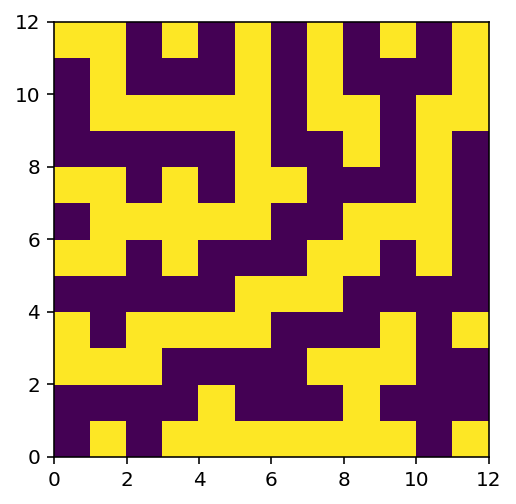

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

maze = NDMaze(2)
plt.pcolormesh(maze.space)
plt.axes().set_aspect('equal')

plt.show()

Notice the wrapping over the edges.

This next class builds such mazes where movement through higher dimensions corresponds to melodic movement of larger intervals: moving through dimension 0 equates to melodic movement in semitones, in dimension 1 by whole tones, and so on...

In [3]:
class IntervalMaze(NDMaze):
                
    def random_maze_cell(self):
        maze_cells = np.transpose(np.where(self.space == 1))
        return tuple(maze_cells[random.randrange(maze_cells.shape[0])])
    
    def cell_note(self, cell):
        return sum((dim + 1) * i for dim, i in enumerate(cell)) % self.size
    
    def maze_neighbours(self, cell, note):
        neighbours = []
        notes = []
        for dim, mod in self.neighbour_mods():
            neigh_ref = self.modified_ref(dim, mod, cell)
            if self.space[neigh_ref] == 1:
                neighbours.append(neigh_ref)
                notes.append(note + (mod * (dim + 1)))
        return neighbours, notes
    
    def next_maze_neighbours(self, played, notes):
        mns, ns = self.maze_neighbours(played[-1], notes[-1])
        return [c for c in mns if c not in played], [n for c, n in zip(mns, ns) if c not in played]
    
    def an_interval_path(self):
        played = [self.random_maze_cell()]
        notes = [self.cell_note(played[-1])]
        while True:
            nmn, poss_notes = self.next_maze_neighbours(played, notes)
            if nmn:
                choice = random.randrange(len(nmn))
                played.append(nmn[choice])
                notes.append(poss_notes[choice])
            else:
                return notes


The .an_interval_path method traces a path through the maze until it reaches a dead end, starting from a random maze cell, and returns values which can correspond to pitch and intervals as described:

In [42]:
maze = IntervalMaze(2)
for _ in range(5):
    print(maze.an_interval_path())

[0, -1, -2, -3, -1, -2, -3, -5, -7, -9, -10, -11, -13, -15, -17, -19, -21, -22, -23, -21]
[5, 6, 4, 5, 6, 8, 9, 10, 11, 12, 13, 15, 17, 19, 18, 17, 15, 14, 13, 12, 11]
[7, 5, 4, 3, 1, 0, -1, -3]
[11, 12, 13, 15, 17, 19, 18, 17, 19, 21, 23, 25, 26, 27, 29, 31, 33, 34, 35, 33, 34, 32, 30, 28, 27, 25, 24, 23]
[0, -2, -1, -3]


Notice that for a 2-dimensional maze, maximum change is 2 (whole-tone).  Let's try 3-dimensional:

In [39]:
maze = IntervalMaze(3)
for _ in range(5):
    print(maze.an_interval_path())

[8, 11, 10, 13, 15, 17, 20, 19, 18, 15, 12, 9, 11, 13, 10, 7, 6, 4, 1, 0, -3, -6, -9, -12, -11, -9, -8]
[11, 10, 7, 6, 8, 7, 6, 9, 12, 13]
[10, 13, 12, 10]
[11, 13, 15, 17, 18, 21, 22, 23, 24, 27, 30]
[1, 4]


Let's have a listen...

In [5]:
import music21

In [48]:
def int_to_note(note, **kwargs):
    """
    Return note middle-C for 0, semitones are 1 big
    """
    return music21.note.Note((note % 12), octave=((note // 12) + 4), **kwargs)


def playable_stream(notes):
    """
    Take a list of note values and return a music21 Stream
    """
    
    output = music21.stream.Stream()
    
    # Patch the MIDI player which drops the first second in some cases
    output.append(music21.note.Rest())
    
    for note in notes:
        output.append(int_to_note(note, type='eighth'))
    
    output.append(music21.note.Rest())
        
    return output


def append_phrase(stream, phrase):
    for note in phrase:
        stream.append(int_to_note(note, type='16th'))


def song_from_maze(maze, phrases=5):
    # score = music21.stream.Score()
    # tempo = music21.tempo.MetronomeMark(number=176)
    # tempo.numberSounding = 176
    # score.append(tempo)
    
    output = music21.stream.Stream()
    
    # Patch the MIDI player which drops the first second in some cases
    output.append(music21.note.Rest())
    
    for phrase_i in range(phrases):
        phrase = music21.stream.Stream()
        phrase_notes = maze.an_interval_path()
        append_phrase(phrase, phrase_notes)
        output.append(phrase)
        output.append(music21.note.Rest(type='16th'))
        
    # patch the MIDI player chopping the end off
    for _ in range(2):
        output.append(music21.note.Rest(type='whole'))
    
    # score.append(output)
    # return score
    return output

In [46]:
maze = IntervalMaze(3)

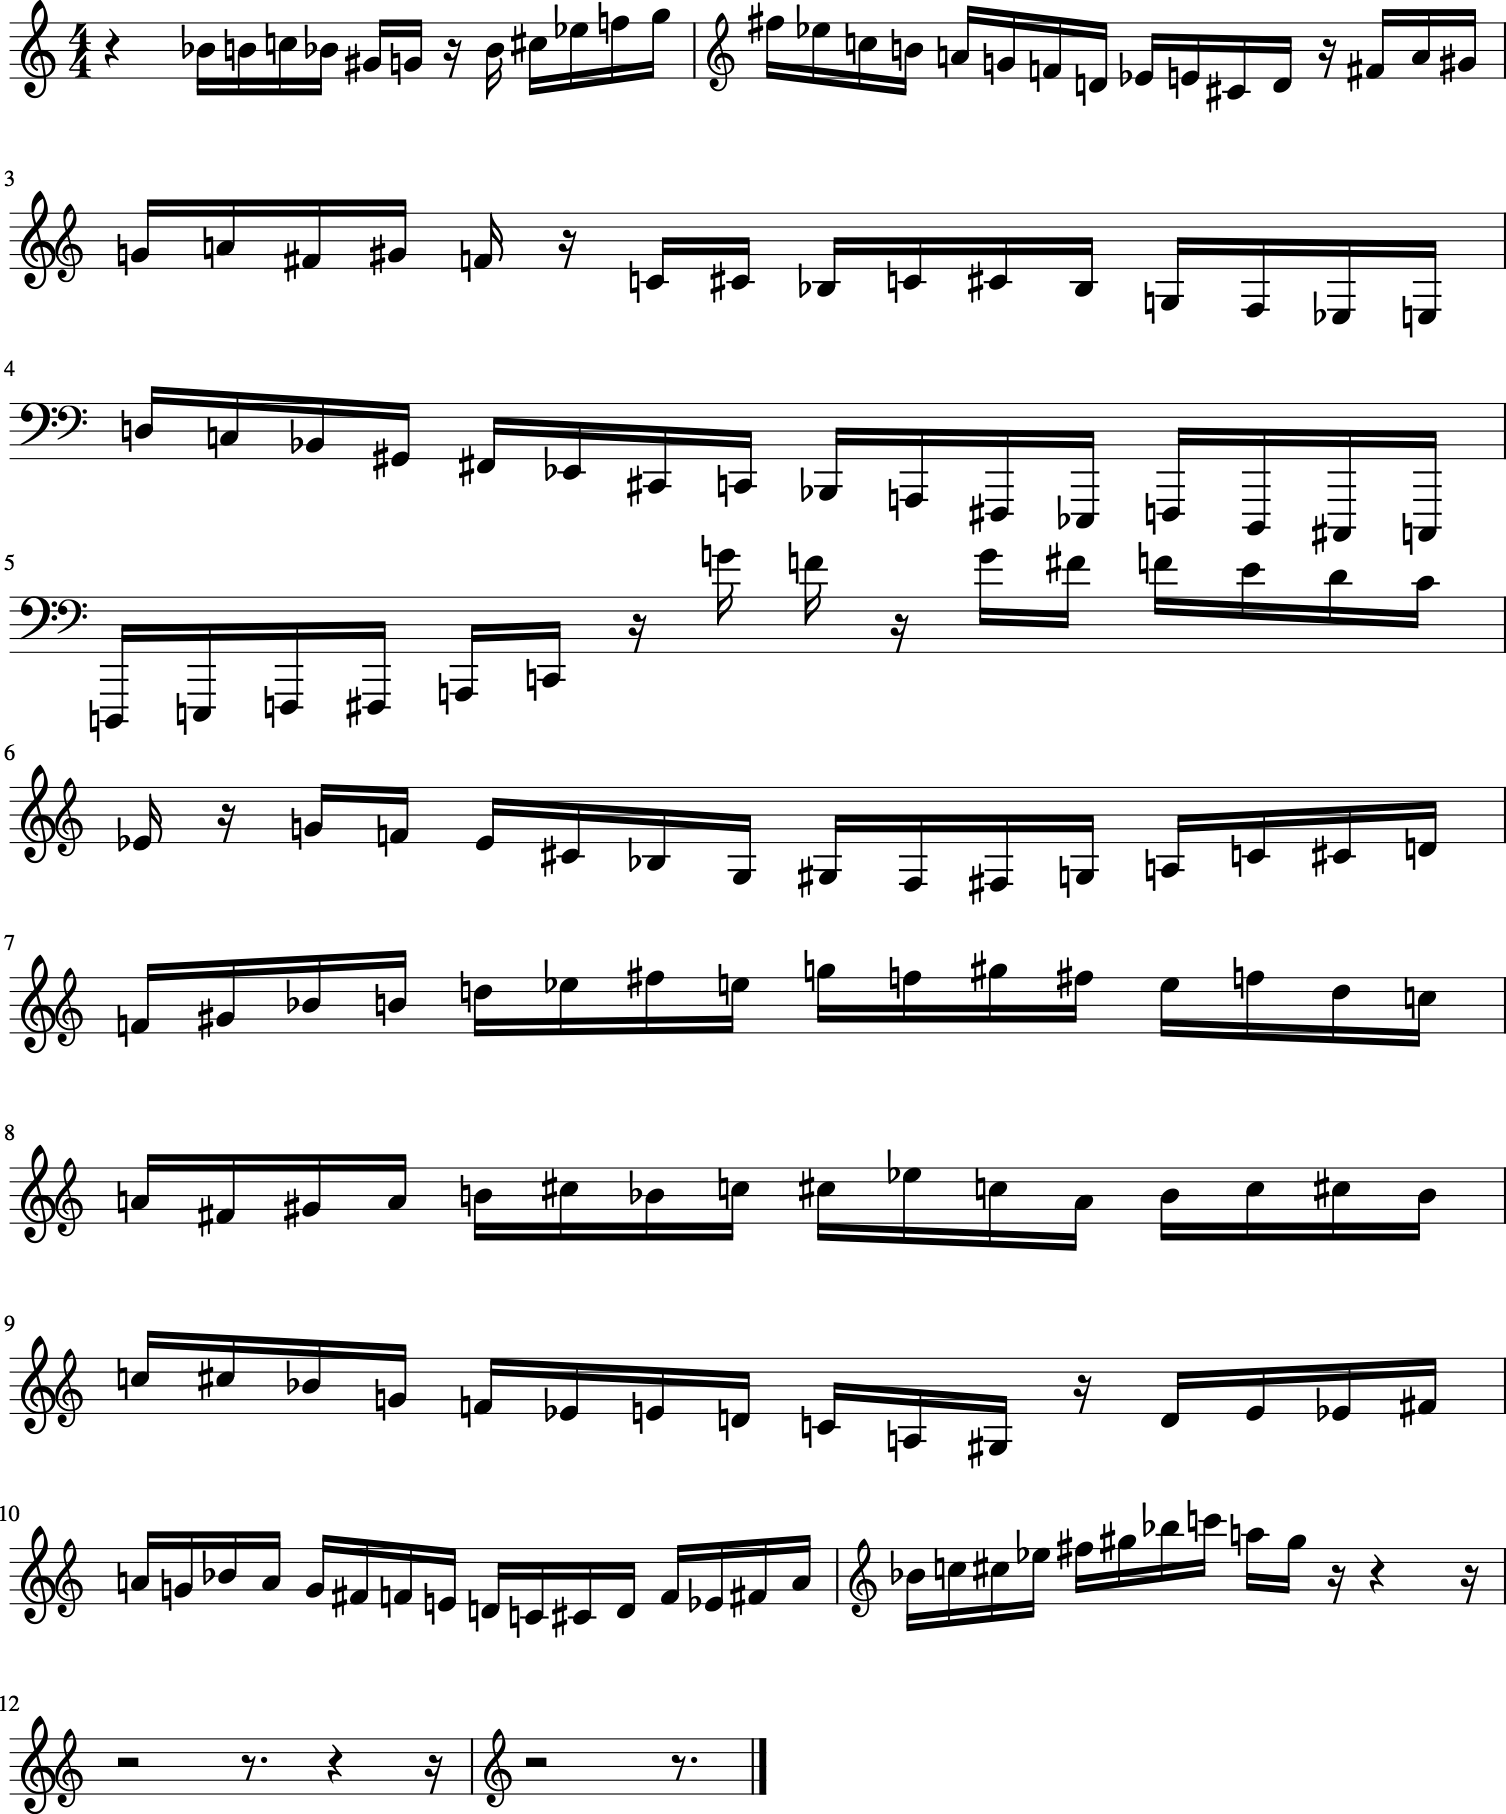

In [49]:
song = song_from_maze(maze, phrases=8)
song.show()
song.show('midi')

If you have trouble with MuseScore path, see below for a workaround.

5-dimensional mazes represent intervals of up to a perfect fourth, and are about the limit for a desktop computer.  They take a while to build (that's 12^5 cells now).  Let's try it:

In [50]:
maze = IntervalMaze(5)

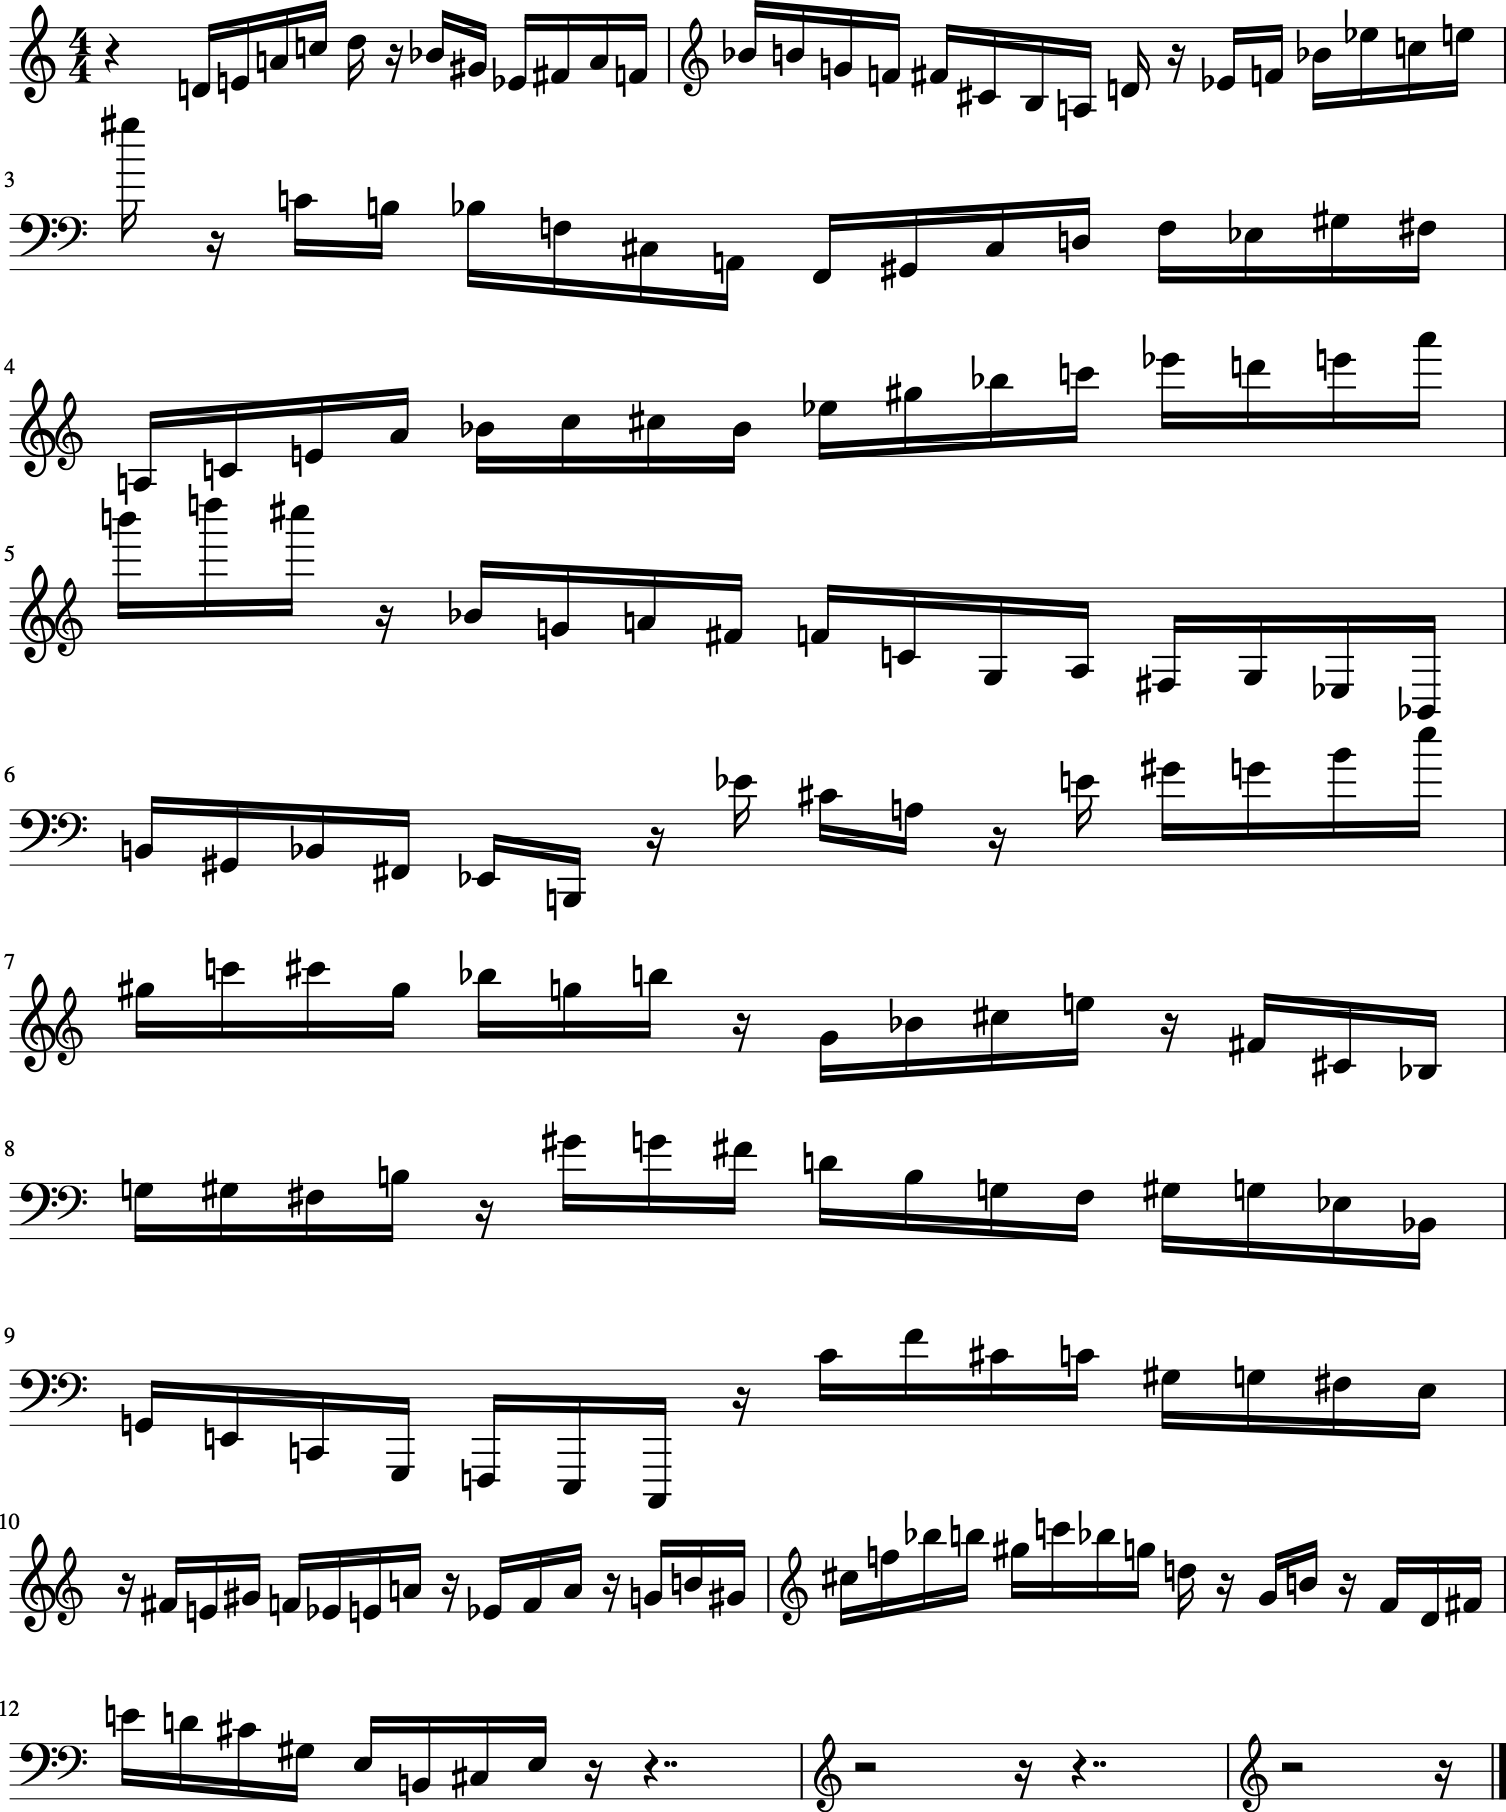

In [52]:
song = song_from_maze(maze, phrases=16)
song.show()
song.show('midi')

## Extension
Other possibilities: 
- map the dimensions to other intervals
- send probabilities for the various intervals to the maze building algorithm, to influence their prevalence 
- build the maze in definable intervalic structures, whole motifs at a time
- ...

A wrapping 3-dimensional maze for your enjoyment:

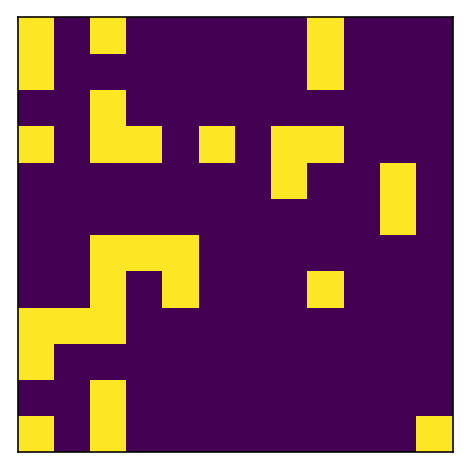

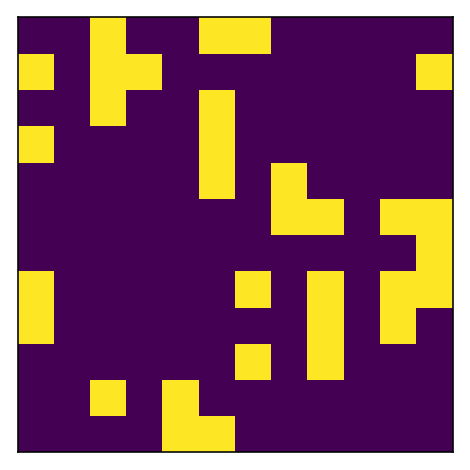

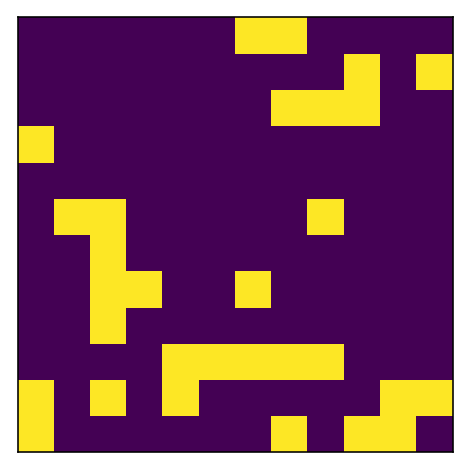

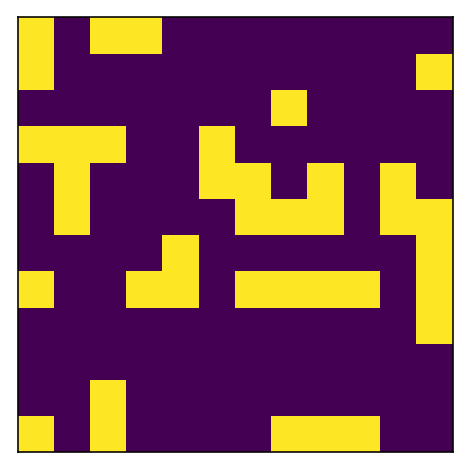

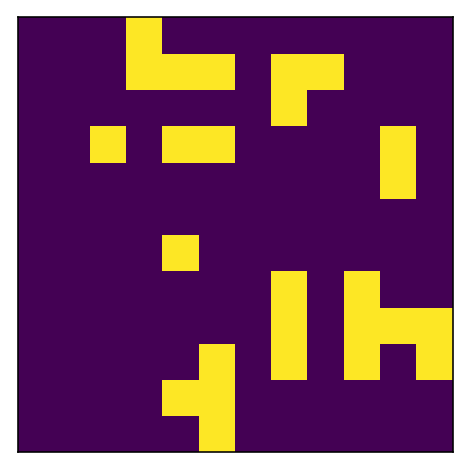

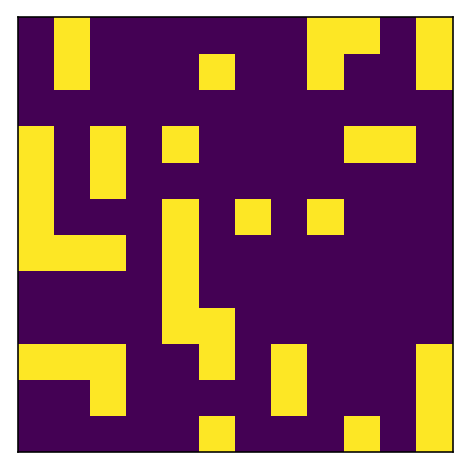

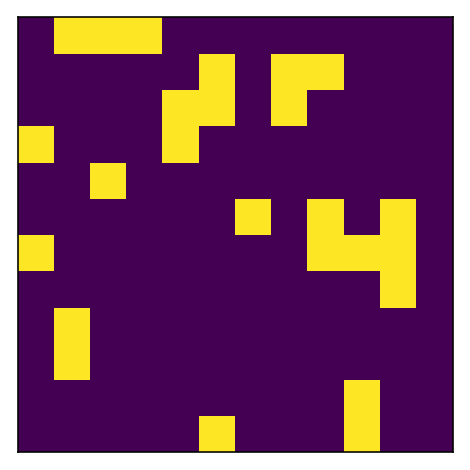

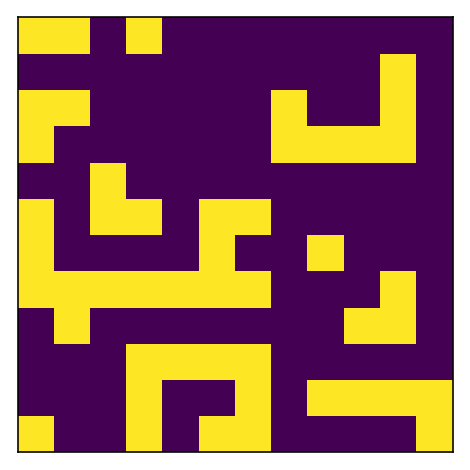

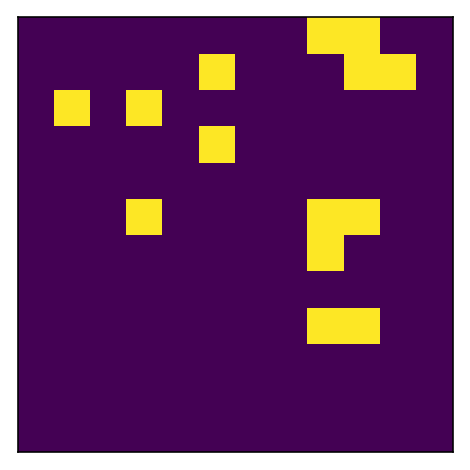

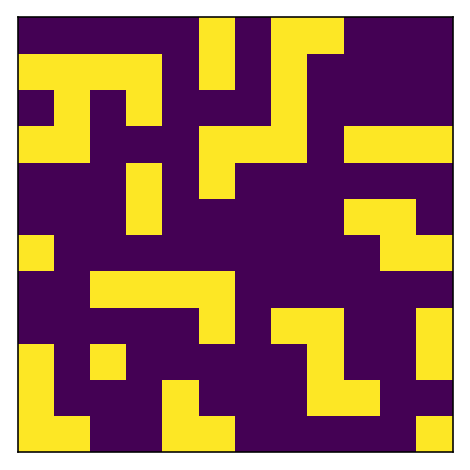

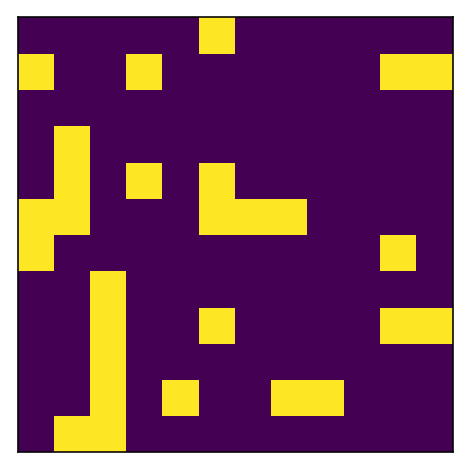

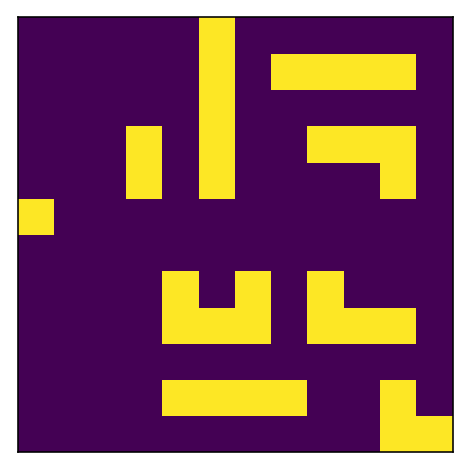

In [53]:
dims = 3
maze3d = NDMaze(dims, debug=False)

for i in range(12):
    plt.pcolormesh(maze3d.space[i])
    plt.axes().set_aspect('equal') #set the x and y axes to the same scale
    plt.xticks([]) # remove the tick marks by setting to an empty list
    plt.yticks([]) # remove the tick marks by setting to an empty list
    plt.show()

In [ ]:
# Use this to set the path to your MuseScore installation, if you have problems:
path = '/Applications/MuseScore 3.app/Contents/MacOS/mscore'

import music21
import pathlib

music21.environment.set('musicxmlPath', pathlib.PosixPath(path))
music21.environment.set('musescoreDirectPNGPath', pathlib.PosixPath(path))

In [ ]:
# tests
assert(len(NDMaze(4).random_cell()) == 4)
assert(NDMaze(4).space.shape == (12, 12, 12, 12))

# assignability test
dims = 5
maze = NDMaze(dims)
cell = tuple(np.random.randint(12) for _ in range(dims))
assert(maze.space[cell] == 0)
maze.space[cell] = 1
assert(maze.space[cell] == 1)

# stack is a list
assert(type(maze.stack) == list)

assert(len(list(maze.neighbour_mods())) == dims * 2)
assert(min(list(maze.neighbour_mods())) == (0, -1))
assert(max(list(maze.neighbour_mods())) == (dims - 1, 1))

# test modified_ref wrapping
dims = 2
maze = NDMaze(dims)
assert(maze.modified_ref(dim=0, modifier=-1, origin=(0, 0)) == (maze.size - 1, 0))

In [ ]:
dims = 3
maze = IntervalMaze(dims)
assert(len(maze.random_maze_cell()) == dims)
for _ in range(10):
    assert(maze.space[maze.random_maze_cell()] == 1)
    
assert(maze.cell_note((1, 1, 1, 1)) == 10)
assert(maze.cell_note((0, 0, 0, 0)) == 0)
assert(maze.cell_note((0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1)) == 0)
assert(maze.cell_note((1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1)) == 1)
assert(maze.cell_note((0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1)) == 4)
assert(maze.cell_note((0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1)) == 0)
assert(maze.cell_note((-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1)) == 11)
for _ in range(10):
    assert(0 <= maze.cell_note(maze.random_maze_cell()) < 12)